# PERSONAL BANK LOAN ANALYSIS

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy.stats import pointbiserialr, spearmanr
%matplotlib inline

## Dataset overview

In [22]:
df = pd.read_csv("/Users/soniaborsi/Desktop/Bank_Personal_Loan_Modelling.csv")
df.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0/40,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1/50,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0/30,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0/60,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8/90,3,0,1,0,0,0,0


In [23]:
df.tail(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4990,4991,55,25,58,95023,4,2/00,3,219,0,0,0,0,1
4991,4992,51,25,92,91330,1,1/90,2,100,0,0,0,0,1
4992,4993,30,5,13,90037,4,0/50,3,0,0,0,0,0,0
4993,4994,45,21,218,91801,2,6/67,1,0,0,0,0,1,0
4994,4995,64,40,75,94588,3,2/00,3,0,0,0,0,1,0
4995,4996,29,3,40,92697,1,1/90,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0/40,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0/30,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0/50,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0/80,1,0,0,0,0,1,1


- ID: ID of the customer

- Age: Age of the customer in completed years

- Experience: Amount of work experience in years

- Income: Amount of annual income (in thousands)

- Zipcode: Postal code in which the client lives

- Family: Number of family members

- CCAvg: Average monthly spending with the credit card (in thousands)

- Education: Education level (1: bachelor's degree, 2: master's degree, 3: advanced/professional degree)

- Mortgage: Value of home mortgage, if any (in thousands)

- Securities Account: Does the customer have a securities account with the bank?

- CD Account: Does the customer have a certificate of deposit account (CD) with the bank?

- Online: Does the customer use the internet banking facilities?

- CreditCard: Does the customer use a credit card issued by the bank?

- Personal Loan: Did this customer accept the personal loan offered in the last campaign? (Target Variable)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


In [25]:
df.isnull().sum().sum()

0

In [26]:
df['Personal Loan'].value_counts()

Personal Loan
0    4520
1     480
Name: count, dtype: int64

In [27]:
pd.set_option('display.max_rows', 20)
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.50,1443.52,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.34,11.46,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.10,11.47,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.77,46.03,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.50,2121.85,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.40,1.15,1.0,1.00,2.0,3.00,4.0
Education,5000.0,1.88,0.84,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.50,101.71,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.10,0.29,0.0,0.00,0.0,0.00,1.0
Securities Account,5000.0,0.10,0.31,0.0,0.00,0.0,0.00,1.0


In [28]:
df.duplicated().sum()

0

In [29]:
df['CCAvg'] 

0       1/60
1       1/50
2       1/00
3       2/70
4       1/00
        ... 
4995    1/90
4996    0/40
4997    0/30
4998    0/50
4999    0/80
Name: CCAvg, Length: 5000, dtype: object

In [30]:
df['CCAvg'] = df['CCAvg'].astype(str).str.replace('/', '.')
df['CCAvg'] = pd.to_numeric(df['CCAvg'], errors='coerce')

df['CCAvg']

0       1.6
1       1.5
2       1.0
3       2.7
4       1.0
       ... 
4995    1.9
4996    0.4
4997    0.3
4998    0.5
4999    0.8
Name: CCAvg, Length: 5000, dtype: float64

### Correlation

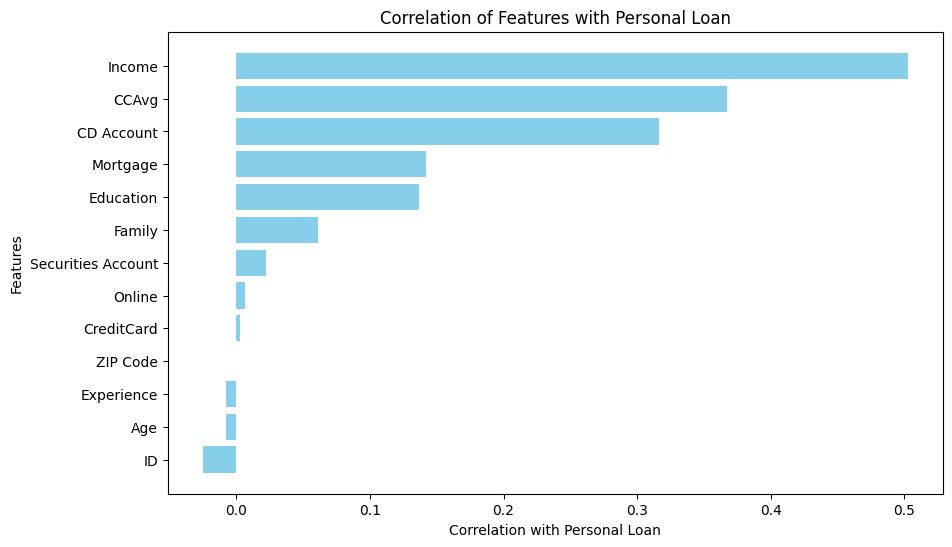

In [31]:

correlation_results = {}

for col in df.columns:
    if col != 'Personal Loan':
        # If the column is numeric, perform point biserial correlation
        if np.issubdtype(df[col].dtype, np.number):
            correlation, _ = pointbiserialr(df['Personal Loan'], df[col])
            correlation_results[col] = correlation
        else:
            # For categorical or ordinal data, use Spearman correlation
            correlation, _ = spearmanr(df['Personal Loan'], df[col])
            correlation_results[col] = correlation

correlation_df = pd.DataFrame(list(correlation_results.items()), columns=['Feature', 'Correlation'])
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(correlation_df['Feature'], correlation_df['Correlation'], color='skyblue')
plt.xlabel('Correlation with Personal Loan')
plt.ylabel('Features')
plt.title('Correlation of Features with Personal Loan')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest correlation at the top
plt.show()


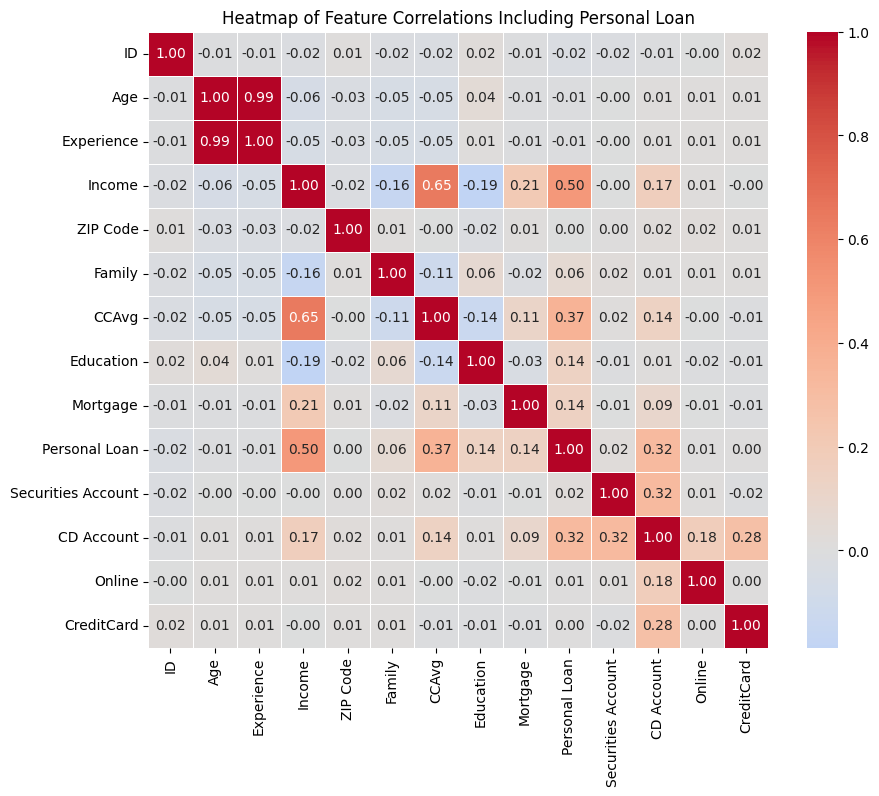

In [32]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')
plt.title('Heatmap of Feature Correlations Including Personal Loan')
plt.show()


## Data cleaning

1. Check negative values in Experience and remove noise

In [33]:
df[df['Experience']<0]['Experience'].count()

52

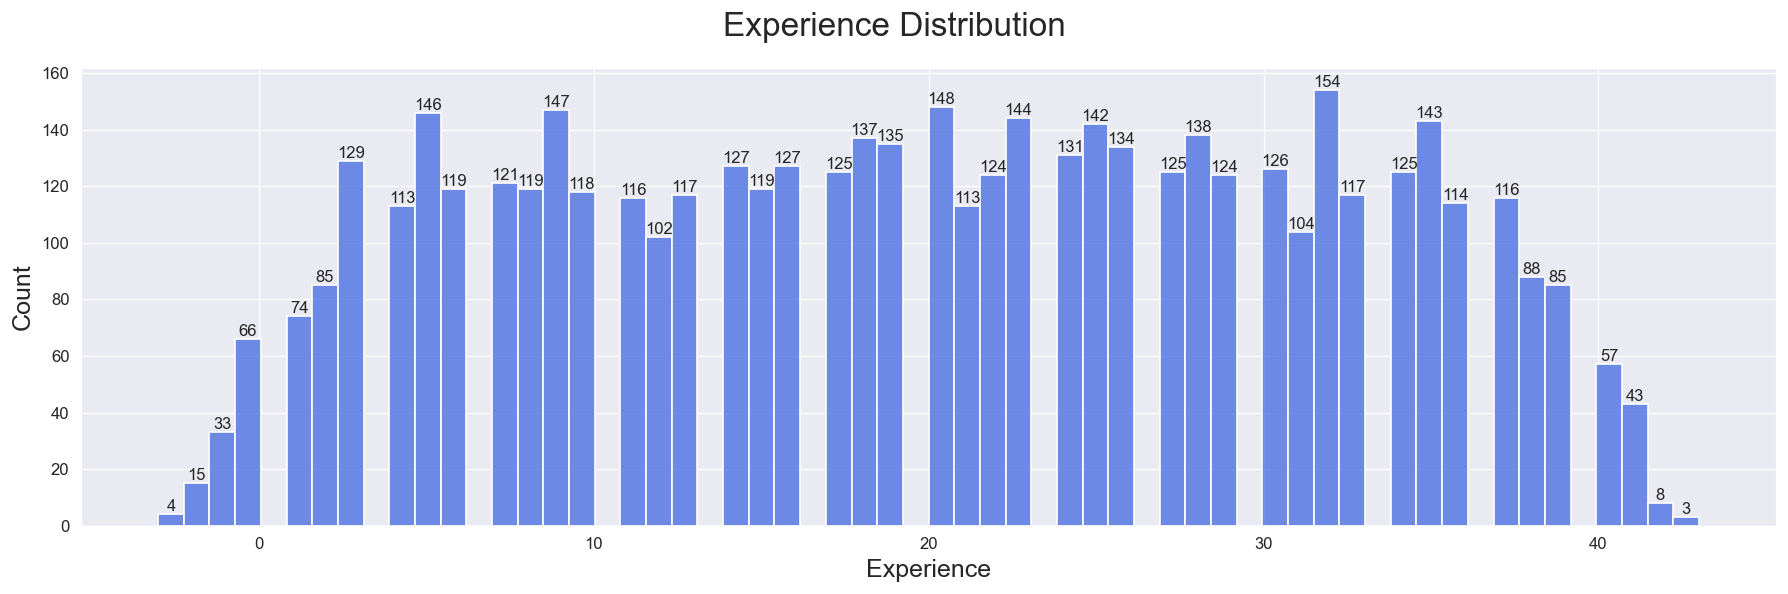

In [34]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='Experience', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15, 
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('Experience', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('Experience Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [35]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

Replace negative values with their absolute value

In [18]:
df['Experience'] = df['Experience'].apply(abs)

2. Drop ID column

In [125]:
df.drop(['ID'], axis= 1, inplace= True)

3. remove outliers from mortage using Z-score

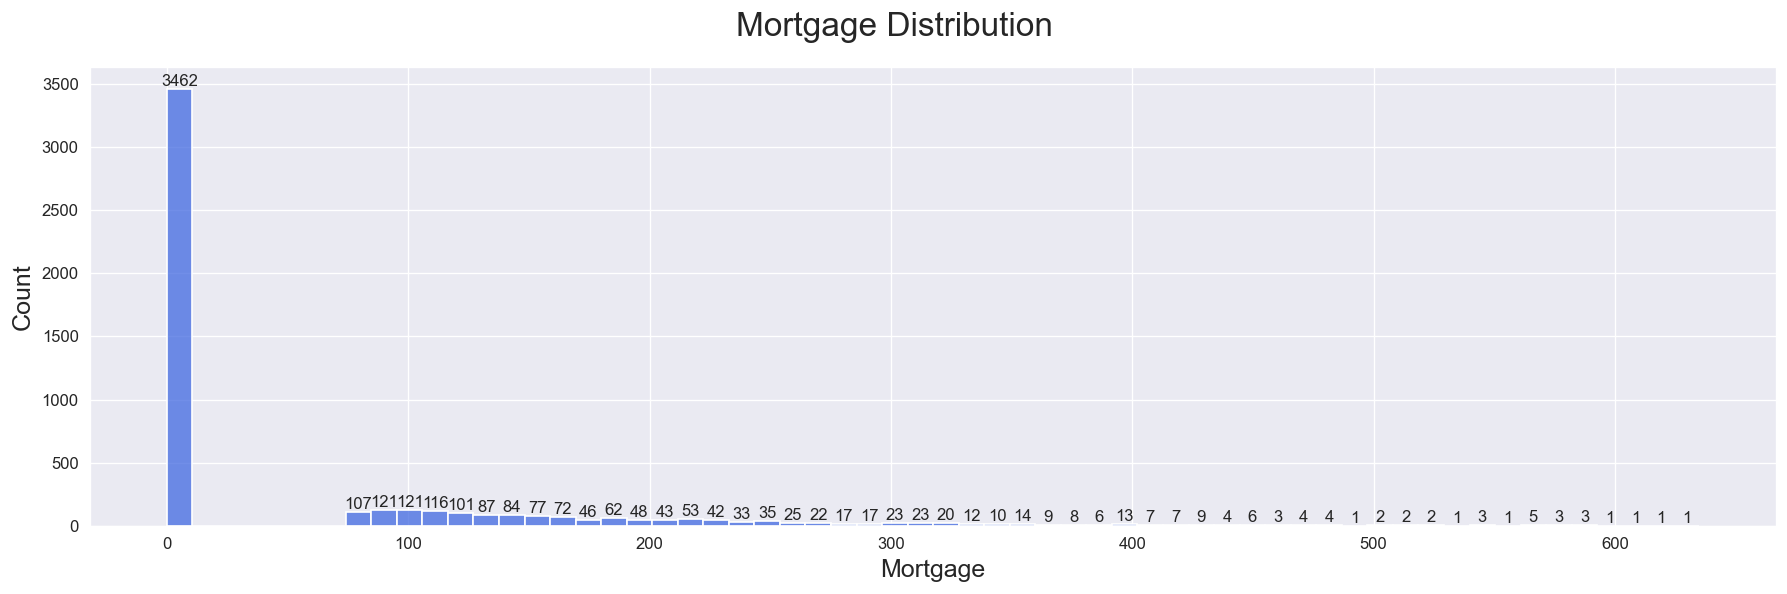

In [323]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='Mortgage', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15, 
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('Mortgage', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [40]:
z_scores = np.abs(stats.zscore(df['Mortgage']))
threshold = 3
df_no_outliers = df[(z_scores < threshold)]

4. Drop ZIP code column

In [126]:
df.drop(['ZIP Code'], axis= 1, inplace= True)

## Divide in train and test

### Oversampling for unbalanced classes

In [127]:
X = df.drop('Personal Loan', axis=1)  
y = df['Personal Loan']  

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [128]:
y_resampled.value_counts()

Personal Loan
0    4520
1    4520
Name: count, dtype: int64

### Divide in train and test resampled df

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(7232, 11) (7232,)
(1808, 11) (1808,)


# Models

## Logistic Regression

In [130]:
scaler = StandardScaler()

pipeline_logreg = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])


In [131]:
pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = pipeline_logreg.predict(X_test)
logreg = pipeline_logreg.named_steps['logreg']

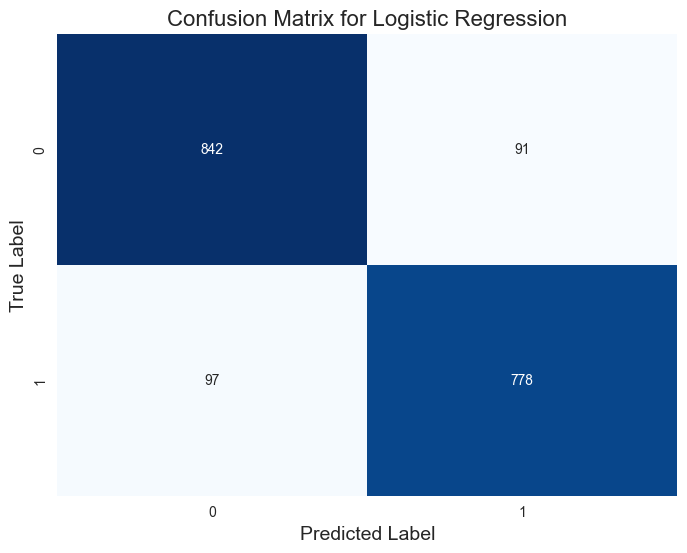

In [132]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Logistic Regression', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

In [133]:
accuracy = accuracy_score(y_test, y_pred_logreg)
precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f1 = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, pipeline_logreg.predict_proba(X_test)[:, 1]
)

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc_logreg]
})

metrics_table

,Metric,Score
0,Accuracy,0.896018
1,Precision,0.895282
2,Recall,0.889143
3,F1 Score,0.892202
4,ROC AUC,0.955928


- feature importance

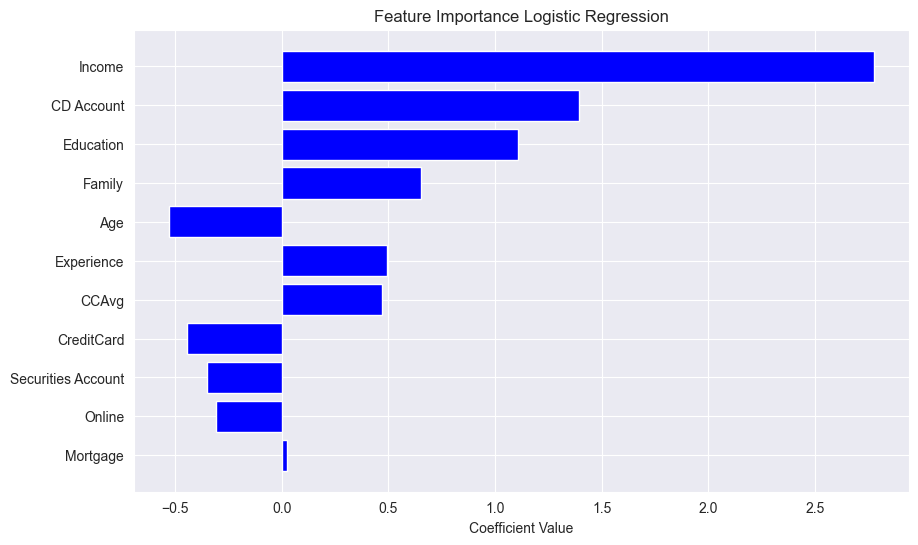

In [134]:
coefficients_lr = logreg.coef_.flatten()

features = X_train.columns  
importance_lr = pd.DataFrame({
    'Feature': features,
    'Importance': coefficients_lr
})

importance_lr['Absolute Importance'] = np.abs(importance_lr['Importance'])
importance = importance_lr.sort_values(by='Absolute Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='b')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance Logistic Regression')
plt.gca().invert_yaxis()  
plt.show()

## Random Forest

In [135]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],            
    'max_depth': [3, 5, 7],                    
    'min_samples_split': [10, 15, 20],         
    'min_samples_leaf': [5, 10],               
    'bootstrap': [True]                        
}

In [136]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')  
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=10, n_jobs=-1, verbose=1) 

In [137]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 5, 7],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [50, 100, 150]},
             verbose=1)

In [138]:
print("Best params:")
print(grid_search.best_params_)

Best params:
{'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


### Predict using best rf

In [141]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
# classification_report(y_test, y_pred)

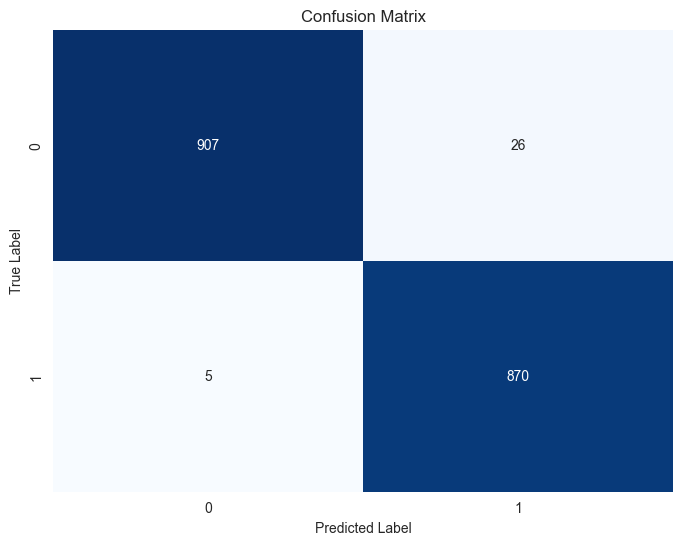

In [142]:
conf_matrix_rf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [143]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})

metrics_table

,Metric,Score
0,Accuracy,0.982854
1,Precision,0.970982
2,Recall,0.994286
3,F1 Score,0.982496
4,ROC AUC,0.998092


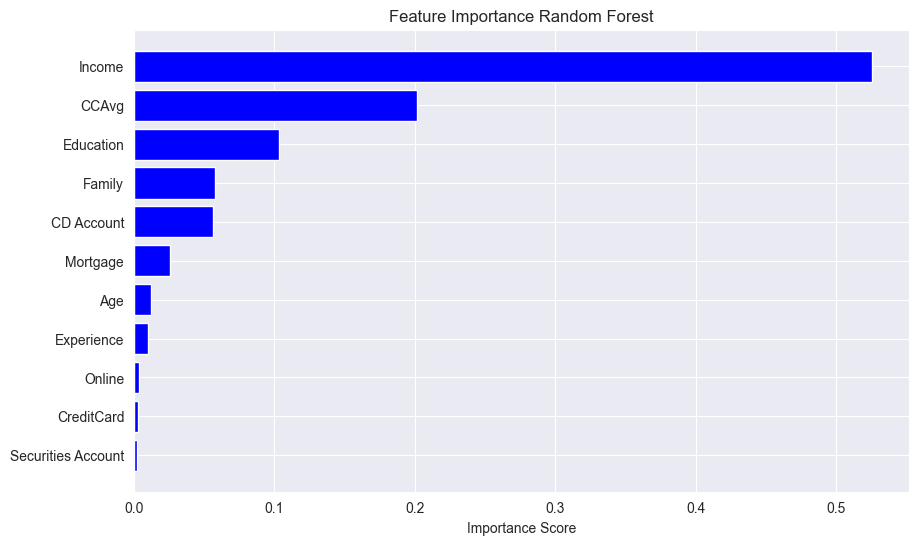

In [144]:
feature_importances_rf = best_rf.feature_importances_
importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_rf
})

importance_rf = importance_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_rf['Feature'], importance_rf['Importance'], color='b')
plt.xlabel('Importance Score')
plt.title('Feature Importance Random Forest')
plt.gca().invert_yaxis()  
plt.show()

## Gradient Boosting

In [145]:
param_grid_gb = {
    'n_estimators': [50, 100, 150],         
    'learning_rate': [0.01, 0.05, 0.1],   
    'max_depth': [3, 4, 5],                
    'min_samples_split': [10, 15],         
    'min_samples_leaf': [5, 10],           
    'subsample': [0.6, 0.8],               
}

In [146]:
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=10, n_jobs=-1, verbose=1)

In [147]:
grid_search_gb.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.6, 0.8]},
             verbose=1)

In [148]:
print("Best params:")
print(grid_search_gb.best_params_)

Best params:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 0.8}


Predict using best gb

In [150]:
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
# classification_report(y_test, y_pred_gb

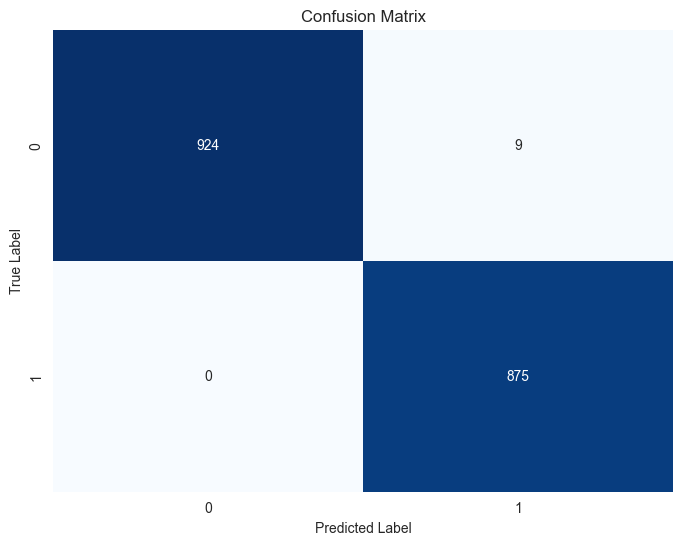

In [151]:
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [152]:
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
roc_auc = roc_auc_score(y_test, best_gb.predict_proba(X_test)[:, 1])

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})

metrics_table

,Metric,Score
0,Accuracy,0.995022
1,Precision,0.989819
2,Recall,1.000000
3,F1 Score,0.994883
4,ROC AUC,0.999973


- feature importance

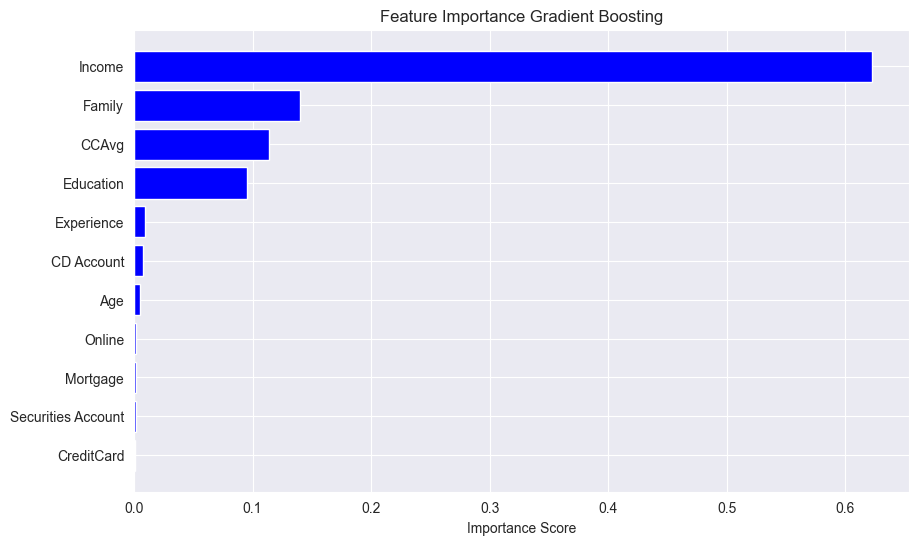

In [153]:
feature_importances_gb = best_gb.feature_importances_
importance_gb = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_gb
})

importance_gb = importance_gb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_gb['Feature'], importance_gb['Importance'], color='b')
plt.xlabel('Importance Score')
plt.title('Feature Importance Gradient Boosting')
plt.gca().invert_yaxis()  #
plt.show()

## Performance comparison

In [154]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)


y_pred_gb = grid_search_gb.best_estimator_.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

metrics_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Test Accuracy': [accuracy_logreg, accuracy_rf, accuracy_gb]
})

metrics_table

,Model,Test Accuracy
0,Logistic Regression,0.896018
1,Random Forest,0.982854
2,Gradient Boosting,0.995022


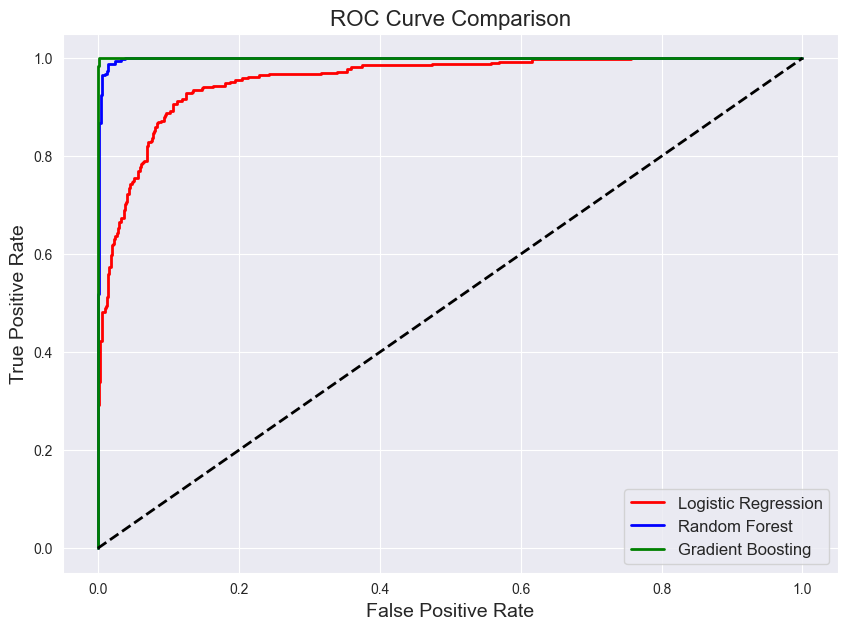

In [155]:
y_pred_logreg_proba = pipeline_logreg.predict_proba(X_test)[:, 1]  # Logistic Regression probabilities
y_pred_rf_proba = best_rf.predict_proba(X_test)[:, 1]  # Random Forest probabilities
y_pred_gb_proba = grid_search_gb.best_estimator_.predict_proba(X_test)[:, 1]  # Gradient Boosting probabilities

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg_proba)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb_proba)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression', color='red', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest', color='blue', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting', color='green', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()


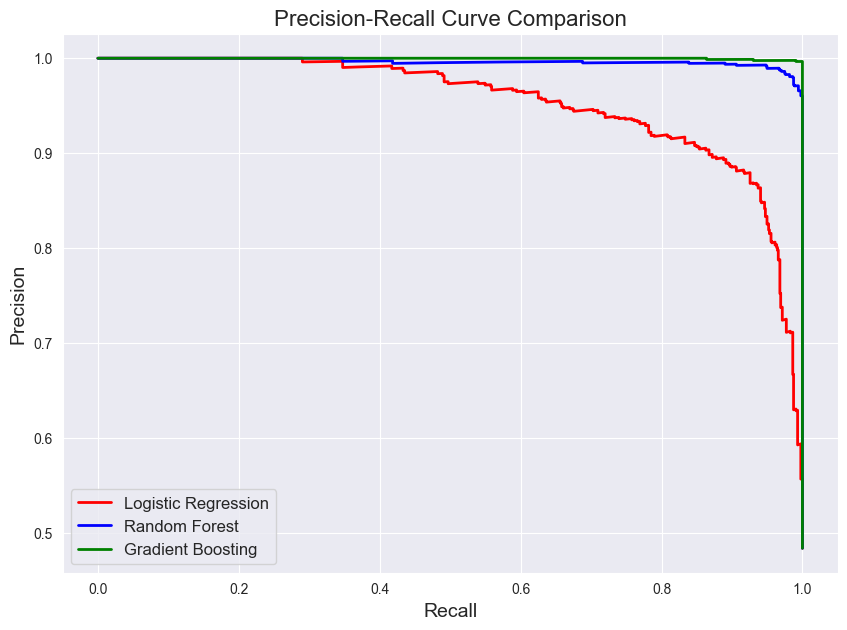

In [84]:
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_logreg_proba)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_proba)
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_gb_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression', color='red', linewidth=2)
plt.plot(recall_rf, precision_rf, label='Random Forest', color='blue', linewidth=2)
plt.plot(recall_gb, precision_gb, label='Gradient Boosting', color='green', linewidth=2)

plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='lower left', fontsize=12)
plt.grid(True)
plt.show()


## Model interpretability

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


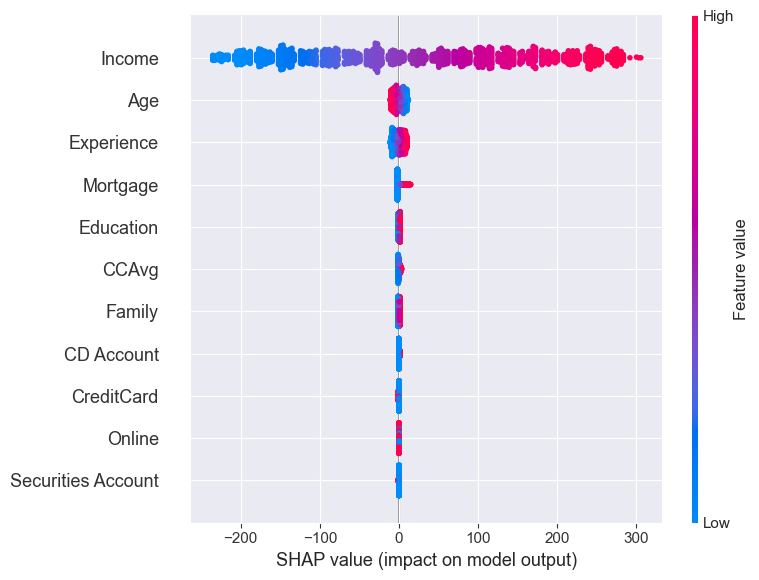

In [156]:
explainer_logreg = shap.LinearExplainer(pipeline_logreg.named_steps['logreg'], X_train, feature_perturbation="interventional")
shap_values_logreg = explainer_logreg.shap_values(X_test)
shap.summary_plot(shap_values_logreg, X_test, feature_names=X_test.columns)

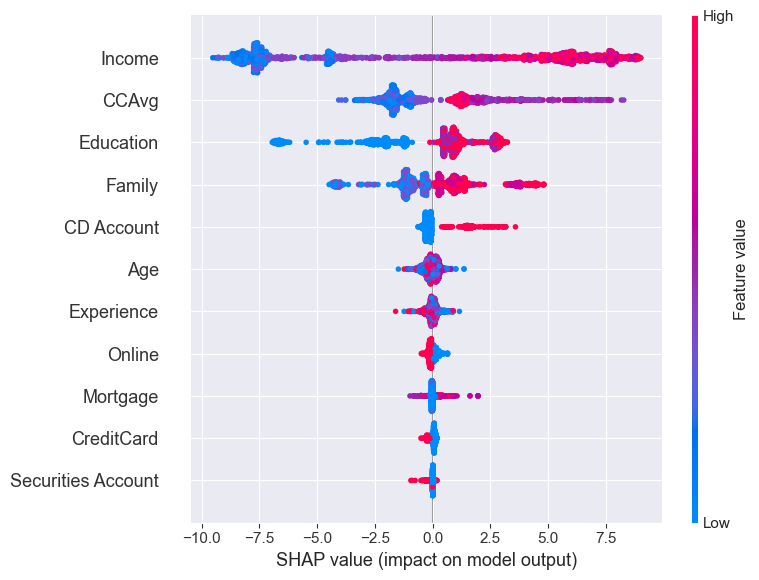

In [158]:

explainer_gb = shap.Explainer(best_gb) 
shap_values_gb = explainer_gb.shap_values(X_test)
shap.summary_plot(shap_values_gb, X_test, feature_names=X_test.columns)


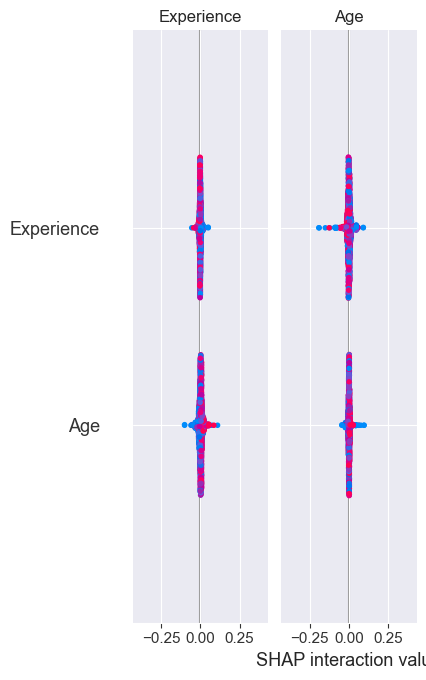

In [159]:
explainer_rf = shap.Explainer(best_rf) 
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns)